# Summary
The goal of this assignment is to build a classifier to classify some grayscale images of the size 28x28 into a set of categories. The dimension of the original data is large, so you need to be smart on which method you gonna use and perhaps perform a pre-processing step to reduce the amount of computation. Part of your marks will be a function of the performance of your classifier on the test set.

## Dataset description
The dataset can be downloaded from Canvas. The dataset consists of a training set of 30,000 examples and a test set of 5,000 examples. They belong to 10 different categories. The validation set is not provided, but you can randomly pick a subset of the training set for validation. The labels of the first 2,000 test examples are given, you will analyse the performance of your proposed method by exploiting the 2,000 test examples. It is NOT allowed to use any examples from the test set for training; or it will be considered as cheating. The rest 3,000 labels of the test set are reserved for marking purpose. <br />
Here are examples illustrating sample of the dataset (each class takes one row):

<img src="Dataset_image.jpg" alt="DataSet" title="DataSet" width="450" height="300" />

There are 10 classes in total:<br />
0 T-shirt/Top<br />
1 Trouser<br />
2 Pullover<br />
3 Dress<br />
4 Coat<br />
5 Sandal<br />
6 Shirt<br />
7 Sneaker<br />
8 Bag<br />
9 Ankle boot <br />

### How to load the data
There is a data folder with 4 main files (which can be downloaded from Canvas):
    1. images_training.h5
    2. labels_training.h5
    3. images_testing.h5
    4. labels_testing_2000.h5

To read the hdf5 file and load the data into a numpy array, assuming the **training data files are in the ./data/train** and **testing data file are in ./data/test**. <br /> Use the following code:

Then data would be a numpy array of the shape (30000, 784), and
label would be a numpy array of the shape (30000, ).
The file images_testing.h5 can be loaded in a similar way.

In [1]:
import h5py
import numpy as np
import os
print(os.listdir("./data/train"))

['images_training.h5', 'labels_training.h5']


In [12]:
# Loading Train Data-set
with h5py.File('./data/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./data/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# Loading Test Data-set
with h5py.File('./data/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./data/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

# using H['datatest'], H['labeltest'] for test dataset.

print(data_train.shape,label_train.shape)
print(data_test.shape,label_test.shape)

(30000, 784) (30000,)
(10000, 784) (2000,)


In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Showing a sample data. The first example belongs to class 0: T-Shirt/Top

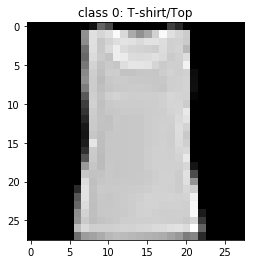

In [7]:
import matplotlib.pyplot as plt
data_train = data_train.reshape((data_train.shape[0], 28, 28))
plt.imshow(data_train[0], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_train[0]) + ": T-shirt/Top" )
plt.show()

### How to output the prediction
Output a file “predicted_labels.h5” that can be loaded in the same way as above. You may use the following code to generate an output file that meets the requirement:

In [10]:
import numpy as np
# assume output is the predicted labels
#(5000,) 
with h5py.File('predicted_labels.h5','w') as H:
    H.create_dataset('output',data=output)

We will load the output file using the code for loading data above. It is your responsibility to make sure the output file can be correctly loaded using this code.
The performance of your classifier will be evaluated in terms of the top-1 accuracy metric, i.e.<br /><br />
<div style="text-align: center"> $$\text{Accuracy} = \frac{\text{Number of correct classifications}}{\text{Total number of test examples used}} * 100\%$$

## Task description

This assignment must be submitted in Python3. Although you are allowed to use external libraries for optimisation and linear algebraic calculations, you are NOT allowed to use external libraries for basic pre-processing or classification. For instance, you are allowed to use scipy.optimize for gradient descent or scipy.linalg.svd for matrix decomposition. However, you are NOT allowed to use sklearn.svm for classification (i.e. you have to implement the classifier yourself)

### The report must clearly show :
    1. Details of your classifier 
    2. The predicted results from your classifier on test examples
    3. Run-time
    4. Hardware and software specifications of the computer that you used for performance evaluation

We shall see a 5 example and see how these images look. 

In [4]:
#Original image is found by reshaping the rows
orig_img = data_train.reshape((data_train.shape[0], 28, 28))

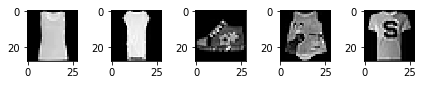

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=5)

i=0
for x in axes:
    x.imshow(orig_img[i], cmap = 'gist_gray')
    i += 1
fig.tight_layout()

In [13]:
# We’ll normalize the data to keep our gradients manageable
data_train = data_train / 255

In [14]:
# Then we’ll one-hot encode Cloth’s labels,
digits = 10
examples = label_train.shape[0]

label_train = label_train.reshape(1, examples)

Y_new = np.eye(digits)[label_train.astype('int32')]
Y_new = Y_new.T.reshape(digits, examples)

Now we will divide the training data into two sets. Training set and Validation set. Training set to implement the model and the validation set to validate the workings. 

In [15]:
m = 24000
m_test = data_train.shape[0] - m

X_train, X_test = data_train[:m].T, data_train[m:].T
Y_train, Y_test = Y_new[:,:m], Y_new[:,m:]

shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle_index], Y_train[:, shuffle_index]

In [17]:
# Shape of the training data
X_train.shape

(784, 24000)

We shall see how we have encoded as per the image of the clothing

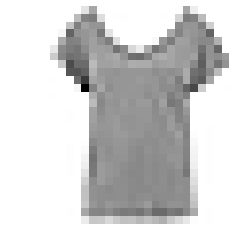

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
import matplotlib.pyplot as plt
i = 12
plt.imshow(X_train[:,i].reshape(28,28), cmap = "Greys")
plt.axis("off")
plt.show()
Y_train[:,i]

In [19]:
image_size = 28
image_pixels = image_size * image_size

In [20]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(784, 24000) (10, 24000) (784, 6000) (10, 6000)


In [21]:
# sigmoid function
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

Our cost function now has to generalize to more than two classes. Now we will define the multi-class loss,

In [22]:
def compute_multiclass_loss(Y, Y_hat):

    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1/m) * L_sum

    return L

A softmax generalizes the sigmoid activiation. Along with the weights calculations, we will also calculate the runtime of the model. 

In [23]:
import time
start_time = time.time()

n_x = X_train.shape[0]
n_h = 64
learning_rate = 1

W1 = np.random.randn(n_h, n_x)
b1 = np.zeros((n_h, 1))
W2 = np.random.randn(digits, n_h)
b2 = np.zeros((digits, 1))

X = X_train
Y = Y_train

for i in range(2000):

    Z1 = np.matmul(W1,X) + b1
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2,A1) + b2
    A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

    cost = compute_multiclass_loss(Y, A2)

    dZ2 = A2-Y
    dW2 = (1./m) * np.matmul(dZ2, A1.T)
    db2 = (1./m) * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1 * sigmoid(Z1) * (1 - sigmoid(Z1))
    dW1 = (1./m) * np.matmul(dZ1, X.T)
    db1 = (1./m) * np.sum(dZ1, axis=1, keepdims=True)

    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1

    if (i % 100 == 0):
        print("Epoch", i, "cost: ", cost)

print("Final cost:", cost)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0 cost:  6.386535556415009
Epoch 100 cost:  2.2935844781309074
Epoch 200 cost:  2.241184068916077
Epoch 300 cost:  2.2028972714878097
Epoch 400 cost:  2.1686638870404504
Epoch 500 cost:  2.1537352177161693
Epoch 600 cost:  2.132624423005434
Epoch 700 cost:  2.107907441792127
Epoch 800 cost:  2.081996956815647
Epoch 900 cost:  2.055353917783481
Epoch 1000 cost:  2.0280557329374673
Epoch 1100 cost:  2.0000820453526944
Epoch 1200 cost:  1.9713775967621519
Epoch 1300 cost:  1.9418586954538402
Epoch 1400 cost:  1.9113812127423566
Epoch 1500 cost:  1.8795817454607961
Epoch 1600 cost:  1.8439303030805807
Epoch 1700 cost:  1.886229127398297
Epoch 1800 cost:  1.7647654191941329
Epoch 1900 cost:  1.716554499826086
Final cost: 1.8195069770214525
--- 1385.5266199111938 seconds ---


Let's see how we did on the validation set, before we move forward with our test labels to be predicted

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
Z1 = np.matmul(W1, X_test) + b1
A1 = sigmoid(Z1)
Z2 = np.matmul(W2, A1) + b2
A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

predictions = np.argmax(A2, axis=0)
labels = np.argmax(Y_test, axis=0)

print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

[[484  32  90 180 105  37 242   9  40  35]
 [ 85 536  48 228  36 332  85 244  21   3]
 [  2   1  12   0   1   0   2   0   3   0]
 [ 24   4   6 199  11  66  13 175  61  11]
 [ 23   6 426   8 408   8 236   5 420  41]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   1  35   0   2 107  28  71  55  50]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  45   0 111   0 451]]
              precision    recall  f1-score   support

           0       0.78      0.39      0.52      1254
           1       0.92      0.33      0.49      1618
           2       0.02      0.57      0.04        21
           3       0.32      0.35      0.34       570
           4       0.72      0.26      0.38      1581
           5       0.00      0.00      0.00         0
           6       0.05      0.08      0.06       349
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.76     

C:\Users\alina\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Evaluation of the Test Data-set

In [25]:
# Loading Test Data-set
with h5py.File('./data/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./data/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

In [26]:
print(data_test.shape,label_test.shape)

(10000, 784) (2000,)


In [27]:
new_data_test = data_test[:2000,:]

In [28]:
new_data_test.shape

(2000, 784)

In [29]:
X_test = new_data_test / 255

In [30]:
X_test = X_test.transpose()

In [31]:
X_test.shape

(784, 2000)

In [32]:
digits = 10
examples = label_test.shape[0]

label_test = label_test.reshape(1, examples)

Y_test = np.eye(digits)[label_test.astype('int32')]
Y_test = Y_test.T.reshape(digits, examples)

In [33]:
Y_test.shape

(10, 2000)

Using the Test Data-set on the model created by our model, to predict the values of the 2000 test labels. 

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
Z1 = np.matmul(W1, X_test) + b1
A1 = sigmoid(Z1)
Z2 = np.matmul(W2, A1) + b2
A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

predictions = np.argmax(A2, axis=0)
labels = np.argmax(Y_test, axis=0)

print(confusion_matrix(predictions, labels))
print(classification_report(predictions, labels))

[[167  13  25  81  30   7  72   2  11  16]
 [ 25 158  12  80  13 111  18  81   2   2]
 [  0   0   4   0   1   0   1   0   2   0]
 [ 10   0   2  54   3  19   9  68  20   5]
 [  8   3 117   4 157   1  99   0 159  19]
 [  0   0   0   0   0   1   0   0   0   0]
 [  0   0  11   0   5  38  12  23  18  10]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  11   0  27   0 153]]
              precision    recall  f1-score   support

           0       0.80      0.39      0.53       424
           1       0.91      0.31      0.47       502
           2       0.02      0.50      0.04         8
           3       0.25      0.28      0.26       190
           4       0.75      0.28      0.40       567
           5       0.01      1.00      0.01         1
           6       0.06      0.10      0.07       117
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.75     

Loading the file to store the values of test samples in the predicted labels file

In [35]:
print(data_test.shape,label_test.shape)

(10000, 784) (1, 2000)


In [36]:
X_test = data_test / 255

In [37]:
X_test = X_test.transpose()

In [38]:
X_test.shape

(784, 10000)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
Z1 = np.matmul(W1, X_test) + b1
A1 = sigmoid(Z1)
Z2 = np.matmul(W2, A1) + b2
A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)

output = np.argmax(A2, axis=0)

In [42]:
import numpy as np
# assume output is the predicted labels
#(5000,) 
with h5py.File('predicted_labels.h5','w') as H:
    H.create_dataset('output',data=output)